# Importación de librerías

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt

from keras import layers
from keras import models
from keras.models import Sequential

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras import backend as K

import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import numpy as np

# Algunas funciones comunes



## Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## Plot métricas

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

# Descarga y armado del dataset

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6556, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 6556 (delta 44), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6556/6556), 116.25 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (274/274), done.


In [ ]:
## fijamos los paths
train_path = './GroceryStoreDataset/dataset/train' 
validation_path = './GroceryStoreDataset/dataset/val'
test_path = './GroceryStoreDataset/dataset/test'

# Pre-procesamiento inicial de los datos

Creamos algunos preprocesamientos sin ninguna variación ni aumento de los datos.

In [ ]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 8)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [ ]:
#take a look at output of the generators
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)


#### Dataset de entrenamiento y test

In [ ]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

#### Crear un modelo convolucional base

In [ ]:
rows = 224
cols = 224
channels = 3

model = models.Sequential()
# Primera capa
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
model.add(layers.MaxPooling2D((2, 2)))
# Segunda capa
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
model.add(layers.MaxPooling2D((2, 2)))
# Tercera capa
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
model.add(layers.MaxPooling2D((2, 2)))
# Cuarta capa
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
model.add(layers.MaxPooling2D((2, 2)))
# Convertir los datos
model.add(layers.Flatten())
# Quinta capa
model.add(layers.Dense(512, activation='relu'))
# Clasificación 
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=5,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/5
82/82 [==============================] - 23s 153ms/step - loss: 5.2502 - acc: 0.6212 - val_loss: 1.1508 - val_acc: 0.5574
Epoch 2/5
82/82 [==============================] - 12s 143ms/step - loss: 0.5437 - acc: 0.7894 - val_loss: 0.9702 - val_acc: 0.6047
Epoch 3/5
82/82 [==============================] - 12s 142ms/step - loss: 0.3098 - acc: 0.8920 - val_loss: 1.1092 - val_acc: 0.6351
Epoch 4/5
82/82 [==============================] - 12s 144ms/step - loss: 0.1780 - acc: 0.9394 - val_loss: 1.2307 - val_acc: 0.6047
Epoch 5/5
82/82 [==============================] - 12s 143ms/step - loss: 0.1468 - acc: 0.9561 - val_loss: 1.4955 - val_acc: 0.6182


## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode="nearest",
        rescale=1./255,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

fit_generator_3 = model.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Epoch 1/30
52/52 [==============================] - 41s 735ms/step - loss: 0.7319 - acc: 0.6856 - val_loss: 0.9889 - val_acc: 0.6115
Epoch 2/30
52/52 [==============================] - 38s 721ms/step - loss: 0.6350 - acc: 0.7261 - val_loss: 0.9112 - val_acc: 0.6419
Epoch 3/30
52/52 [==============================] - 38s 725ms/step - loss: 0.5739 - acc: 0.7655 - val_loss: 0.7397 - val_acc: 0.6723
Epoch 4/30
52/52 [==============================] - 38s 723ms/step - loss: 0.5384 - acc: 0.7814 - val_loss: 0.7824 - val_acc: 0.6622
Epoch 5/30
52/52 [==============================] - 38s 722ms/step - loss: 0.5152 - acc: 0.7879 - val_loss: 0.7634 - val_acc: 0.6824
Epoch 6/30
52/52 [==============================] - 38s 725ms/step - loss: 0.5026 - acc: 0.7981 - val_loss: 0.7580 - val_acc: 0.7128
Epoch 7/30
52/52 [==============================] - 38s 727ms/step - loss: 0.4805 - acc: 0.8106 - val_loss: 0.7584 - val_acc: 0.6723
Epoch 8/30
52/52 [==============================] - 39s 732ms/step - 

Pasamos a examinar otro modelo convolucional, modificando función de activación y optimizador en busca de mejores resultados.

In [ ]:
rows = 224
cols = 224
channels = 3

modeltwo = models.Sequential()
# Primera capa
modeltwo.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
modeltwo.add(layers.MaxPooling2D((2, 2)))
# Segunda capa
modeltwo.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
modeltwo.add(layers.MaxPooling2D((2, 2)))
# Tercera capa
modeltwo.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
modeltwo.add(layers.MaxPooling2D((2, 2)))
# Cuarta capa
modeltwo.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(rows,cols,channels)))
modeltwo.add(layers.MaxPooling2D((2, 2)))
# Convertir los datos
modeltwo.add(layers.Flatten())
# Quinta capa
modeltwo.add(layers.Dense(512, activation='relu'))
# Clasificación 
modeltwo.add(layers.Dense(3, activation='sigmoid'))
modeltwo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
modeltwo.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              metrics=['acc'])

fit_generator_3 = model.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Epoch 1/30
52/52 [==============================] - 39s 730ms/step - loss: 0.1761 - acc: 0.9261 - val_loss: 0.7818 - val_acc: 0.7703
Epoch 2/30
52/52 [==============================] - 38s 723ms/step - loss: 0.1759 - acc: 0.9341 - val_loss: 0.6434 - val_acc: 0.8041
Epoch 3/30
52/52 [==============================] - 38s 725ms/step - loss: 0.1704 - acc: 0.9322 - val_loss: 0.7220 - val_acc: 0.7601
Epoch 4/30
52/52 [==============================] - 38s 714ms/step - loss: 0.1678 - acc: 0.9360 - val_loss: 0.7562 - val_acc: 0.7838
Epoch 5/30
52/52 [==============================] - 38s 714ms/step - loss: 0.1530 - acc: 0.9405 - val_loss: 0.6548 - val_acc: 0.7872
Epoch 6/30
52/52 [==============================] - 38s 716ms/step - loss: 0.1426 - acc: 0.9458 - val_loss: 0.8380 - val_acc: 0.7264
Epoch 7/30
52/52 [==============================] - 38s 723ms/step - loss: 0.1611 - acc: 0.9356 - val_loss: 0.5448 - val_acc: 0.8277
Epoch 8/30
52/52 [==============================] - 38s 721ms/step - 

# Fine tuning con VGG16

## Definición del modelo

In [ ]:
vgg16_model = VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Creamos un nuevo modelo tomando las capas del modelo VGG16 y le sacamos la última capa densa que es de clasificación

In [ ]:
model = Sequential()

for i in range(len(vgg16_model.layers)-4):
  model.add(vgg16_model.layers[i])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

Freezamos los pesos de las capas del modelo

In [ ]:
for layer in model.layers:
  layer.trainable = False

Agregamos las últimas capa para la clasificación, la última con 3 neuronas (correspondientes a frutas, verduras y paquetes respectivamente) y función de activación 'softmax'

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

## Entrenamiento sin callbacks y pocas épocas
Dado que se trata de un problema de computer vision para clasificación, consideramos utilizar los siguientes hiper-parámetros:

*   Optimizador RMSprop
*   Accuracy como métrica
*   Validación de loss con 'categorical crossentropy' (por tratarse de un problema de clasificación de imágenes)
*   Cantidad de épocas: 5 (no elegimos más para evitar el overfitting)



In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

fit_tuning_1 = model.fit(train_generator,
                        steps_per_epoch=steps_train,
                        epochs=5,
                        validation_data=validation_generator,
                        validation_steps=steps_valid)

Epoch 1/5
52/52 [==============================] - 91s 1s/step - loss: 1.0045 - acc: 0.7356 - val_loss: 0.4448 - val_acc: 0.7635
Epoch 2/5
52/52 [==============================] - 49s 920ms/step - loss: 0.4086 - acc: 0.8189 - val_loss: 0.3734 - val_acc: 0.7804
Epoch 3/5
52/52 [==============================] - 49s 921ms/step - loss: 0.3396 - acc: 0.8436 - val_loss: 0.3032 - val_acc: 0.8784
Epoch 4/5
52/52 [==============================] - 49s 929ms/step - loss: 0.3163 - acc: 0.8564 - val_loss: 0.4519 - val_acc: 0.8311
Epoch 5/5
52/52 [==============================] - 49s 927ms/step - loss: 0.2674 - acc: 0.8883 - val_loss: 0.3301 - val_acc: 0.8851


### Métricas

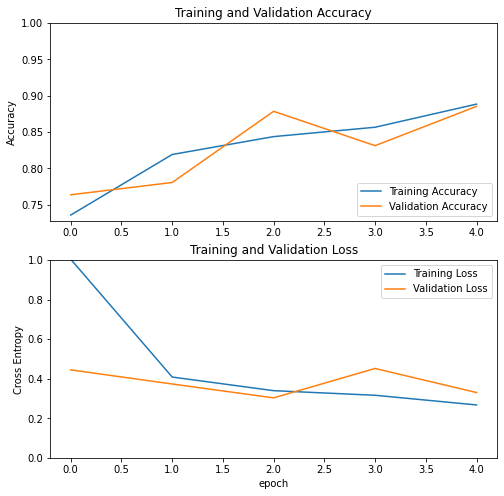

In [ ]:
plot_metrics(fit_tuning_1)

## Entrenamiento con Learning Rate Annealer y mas épocas

Usamos la Learning Rate Annealer, para reducir el learning rate después de cierto número de épocas en los que el error no varía.

En este caso, vamos a permitir como máximo 3 épocas sin cambios para disminuir levemente el valor del learning rate por un factor de 0.01

In [ ]:
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='val_acc',   
                       factor=.01,   
                       patience=3,  
                       min_lr=1e-5) 

In [ ]:
fit_tuning_1_1 = model.fit(train_generator,
                           steps_per_epoch=steps_train,
                           epochs=10,
                           callbacks = [lrr],
                           validation_data=validation_generator,
                           validation_steps=steps_valid)

Epoch 1/10
52/52 [==============================] - 55s 1s/step - loss: 0.0980 - acc: 0.9591 - val_loss: 0.2226 - val_acc: 0.9054 - lr: 1.0000e-05
Epoch 2/10
52/52 [==============================] - 49s 927ms/step - loss: 0.0829 - acc: 0.9689 - val_loss: 0.2508 - val_acc: 0.9122 - lr: 1.0000e-05
Epoch 3/10
52/52 [==============================] - 49s 926ms/step - loss: 0.0773 - acc: 0.9689 - val_loss: 0.2434 - val_acc: 0.9020 - lr: 1.0000e-05
Epoch 4/10
52/52 [==============================] - 49s 927ms/step - loss: 0.0740 - acc: 0.9693 - val_loss: 0.2417 - val_acc: 0.9088 - lr: 1.0000e-05
Epoch 5/10
52/52 [==============================] - 49s 924ms/step - loss: 0.0764 - acc: 0.9742 - val_loss: 0.2409 - val_acc: 0.9189 - lr: 1.0000e-05
Epoch 6/10
52/52 [==============================] - 49s 927ms/step - loss: 0.0674 - acc: 0.9720 - val_loss: 0.2593 - val_acc: 0.8953 - lr: 1.0000e-05
Epoch 7/10
52/52 [==============================] - 49s 927ms/step - loss: 0.0749 - acc: 0.9731 - val_l

### Métricas

En este caso observamos mejoras con respecto al modelo anterior, donde aplicamos menos épocas y no utilizamos callbacks.

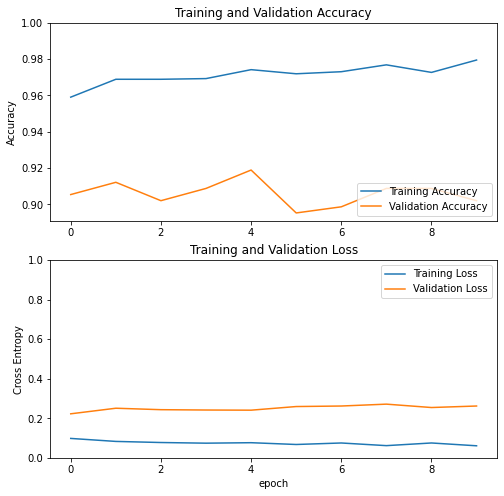

In [ ]:
plot_metrics(fit_tuning_1_1)

# Fine tuning con ResNet50

## Definición del modelo

Se crea la base del modelo con arquitectura ResNet con capas convolucionales pre-entrenadas (no se toman las capas densas del modelo)

In [ ]:
input_shape=(224, 224, 3)

resnet_model = ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape)
resnet_model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

Se dejan freezados los pesos de las capas del modelo base

In [ ]:
for layer in resnet_model.layers:
    layer.trainable = False

Creamos un nuevo modelo tomando las capas del modelo ResNet50 y le sacamos la última capa densa que es de clasificación

In [ ]:
model = Sequential()
model.add(resnet_model)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


Agregamos por último las capas finales para la clasificación, se utiliza el regularizador L2 y se agregan también capas de dropout al 50% para evitar el overfitting.

Por otro lado, también se utiliza como función de activación una sigmoidea en lugar de una softmax (como en los modelos planteados para VGG16) para la última capa densa de la red.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 30,010,499
Trainable params: 6,422,787
Non

## Entrenamiento

Utilizamos parámetros similares al modelo planteado utilizando VGG16, pero aumentando la cantidad de épocas a un total de 10.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

fit_tuning_2 = model.fit(train_batches,
                         steps_per_epoch=steps_train,
                         epochs=10,
                         validation_data=validation_batches,
                         validation_steps=steps_valid)

Epoch 1/10
52/52 [==============================] - 20s 301ms/step - loss: 0.0893 - acc: 0.9774 - val_loss: 0.1728 - val_acc: 0.9500
Epoch 2/10
52/52 [==============================] - 15s 281ms/step - loss: 0.0690 - acc: 0.9810 - val_loss: 0.1339 - val_acc: 0.9583
Epoch 3/10
52/52 [==============================] - 15s 283ms/step - loss: 0.0426 - acc: 0.9900 - val_loss: 0.0797 - val_acc: 0.9750
Epoch 4/10
52/52 [==============================] - 15s 281ms/step - loss: 0.0499 - acc: 0.9905 - val_loss: 0.1661 - val_acc: 0.9583
Epoch 5/10
52/52 [==============================] - 15s 281ms/step - loss: 0.0438 - acc: 0.9905 - val_loss: 0.1192 - val_acc: 0.9750
Epoch 6/10
52/52 [==============================] - 15s 283ms/step - loss: 0.0416 - acc: 0.9912 - val_loss: 0.1419 - val_acc: 0.9625
Epoch 7/10
52/52 [==============================] - 15s 280ms/step - loss: 0.0498 - acc: 0.9893 - val_loss: 0.1420 - val_acc: 0.9625
Epoch 8/10
52/52 [==============================] - 15s 283ms/step - 

## Métricas

Notamos que los valores obtenidos con ResNet50 son mejores en comparación al anterior (utilizando VGG16).

Si bien en ambos se tomaron hiper-parámetros similares, también destacamos la diferencias de aplicar más épocas, capas de dropout y regularizador L2 en el caso de ResNet50.

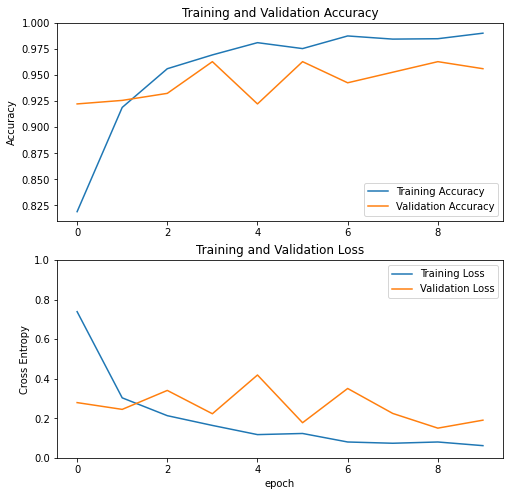

In [ ]:
plot_metrics(fit_tuning_2)

# Conclusiones generales

Si bien ya tuvimos un primer acercamiento con el uso de redes neuronales, el uso particular para imágenes fue intersante ya que no habíamos trabajado previamente con capas convolucionales. 

En este sentido, nos resultó importante entender que la configuración que se plantea para la red, los hiper-parámetros y métricas a considerar varía bastante según la necesidad a resolver.

Por otro lado, para considerar un modelo como "el más óptimo" nos centramos en la métrica "val_acc" que se basa en el accuracy sobre el dataset de validacion. Dichos datos son aquellos que el modelo desconoce por lo cual es la metrica que en realidad deberia interesarnos.


## En cuanto a fine tuning

Encontramos interesante probar distintos hiper-parámetros para la aplicación de los modelos, y en particular el uso de fine tuning simplificó de forma significativa los resultados obtenidos en las métricas. 

Observamos que el uso de las distintas arquitecturas también influyó en los resultados finales, por ejemplo en el caso de ResNet se obtuvieron mejores valores que con VGG16.

Fue interesante ver que no fue necesario aumentar la cantidad de épocas para obtener mejores resultados. Algo de gran impacto fue entender que el freezar inicialmente las capas convolucionales de un modelo pre-entrenado aportaba una mejora significativa y no tanto la modificación de otros hiper-parámetros (como las épocas).

**Por lo anteriormente dicho, hemos seleccionado el modelo ResNet como el más óptimo y el que mejor se adapta a la problemática planteada.**